In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from oracle_functions import S1_ORACLE_fct, S1_bSSFP_Profile_Generation  # Import only the needed functions

# Parameters
TR    = 5 / 1000          # repetition time
TE    = TR / 2            # echo time
nPC   = 20                # number of RF phase increments
theta = 0                 # off resonance
alpha = 15 * np.pi / 180  # RF excitation angle
M0    = 1                 # PD

# number of sampled T1 and T2 times
nT1 = 105
nT2 = 100

# T1 and T2 values which are sampled
T1vec = np.linspace(20, 3000, nT1) / 1000
T2vec = np.linspace(1, 1000, nT2) / 1000

# Sampled RF phase increments (should be phi=[0,2pi[)
phi = np.linspace(0, 2 * np.pi, nPC + 1)[:nPC]

# Monte Carlo parameters
nvari = 500  # number of MonteCarlo runs
SNR   = 100  # signal to noise ratio as a weight for noise

# Vectorized Calculation of bSSFPSignal
T2_grid, T1_grid = np.meshgrid(T2vec, T1vec, indexing='ij')

# Calculate first the mean signal to asign SNR properly
bSSFPSignal = np.zeros((nPC, nT2, nT1), dtype=complex)
for indPC in range(nPC):
    bSSFPSignal[indPC, :, :] = S1_bSSFP_Profile_Generation(
        M0, T1_grid, T2_grid, alpha, phi[indPC], TR, TE, theta
    )

Amax = np.mean(np.abs(bSSFPSignal))

# Vectorized Noise Addition & Error Estimation
T1error = np.zeros((nT1, nT2))
T2error = np.zeros((nT1, nT2))
M0error = np.zeros((nT1, nT2))
B0error = np.zeros((nT1, nT2))

for indT1 in range(nT1):
    for indT2 in range(nT2):
        T1 = T1vec[indT1]
        T2 = T2vec[indT2]

        profile0   = np.zeros((nvari, nPC), dtype=complex)
        theta_rand = 4 * np.pi * np.random.rand(nvari) # variation of off-resonance since we do not want to be dependent on favorable conditions

        for indPC in range(nPC):
            # generate 2D array with all MonteCarlo entries for each phase cylce
            profile0[:, indPC] = S1_bSSFP_Profile_Generation(M0, T1, T2, alpha, phi[indPC], TR, TE, theta_rand)

        noise = (Amax / SNR / np.sqrt(2)) * (np.random.randn(*profile0.shape) + 1j * np.random.randn(*profile0.shape))
        profile = profile0 + noise # add different noise realizations to each montecarlo run (=statistical core)

        # Perform multi parameter quantification in a vectorized way
        results = np.array([S1_ORACLE_fct(profile[i], TR, alpha) for i in range(nvari)])

        # coefficient of variation
        T1error[indT1, indT2] = np.std(results[:, 0] / T1) * 100
        T2error[indT1, indT2] = np.std(results[:, 1] / T2) * 100
        M0error[indT1, indT2] = np.std(results[:, 3] / M0) * 100
        B0error[indT1, indT2] = np.std(np.angle(np.exp(1j * results[:, 2])))

        if indT1 % 1 == 0 and indT2 == 0:
            print(f"Progress: {indT1/nT1*100:.1f}%")

print("Computation Complete!")


Progress: 0.0%
Progress: 1.0%
Progress: 1.9%
Progress: 2.9%
Progress: 3.8%
Progress: 4.8%
Progress: 5.7%
Progress: 6.7%
Progress: 7.6%
Progress: 8.6%
Progress: 9.5%
Progress: 10.5%
Progress: 11.4%
Progress: 12.4%
Progress: 13.3%
Progress: 14.3%
Progress: 15.2%
Progress: 16.2%
Progress: 17.1%
Progress: 18.1%
Progress: 19.0%
Progress: 20.0%
Progress: 21.0%
Progress: 21.9%
Progress: 22.9%
Progress: 23.8%
Progress: 24.8%
Progress: 25.7%
Progress: 26.7%
Progress: 27.6%
Progress: 28.6%
Progress: 29.5%
Progress: 30.5%
Progress: 31.4%
Progress: 32.4%
Progress: 33.3%
Progress: 34.3%
Progress: 35.2%
Progress: 36.2%
Progress: 37.1%
Progress: 38.1%
Progress: 39.0%
Progress: 40.0%
Progress: 41.0%
Progress: 41.9%
Progress: 42.9%
Progress: 43.8%
Progress: 44.8%
Progress: 45.7%
Progress: 46.7%
Progress: 47.6%
Progress: 48.6%
Progress: 49.5%
Progress: 50.5%
Progress: 51.4%
Progress: 52.4%
Progress: 53.3%
Progress: 54.3%
Progress: 55.2%
Progress: 56.2%
Progress: 57.1%
Progress: 58.1%
Progress: 59.0%
Pro

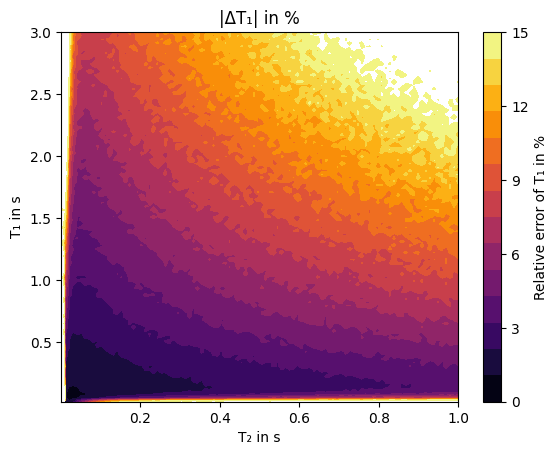

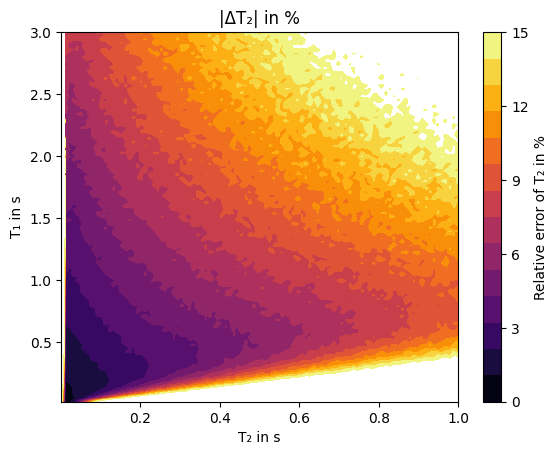

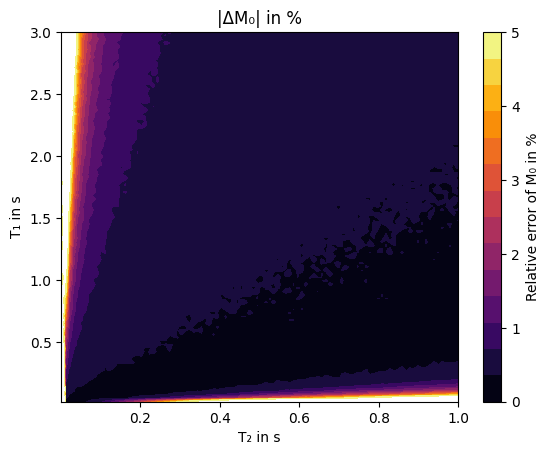

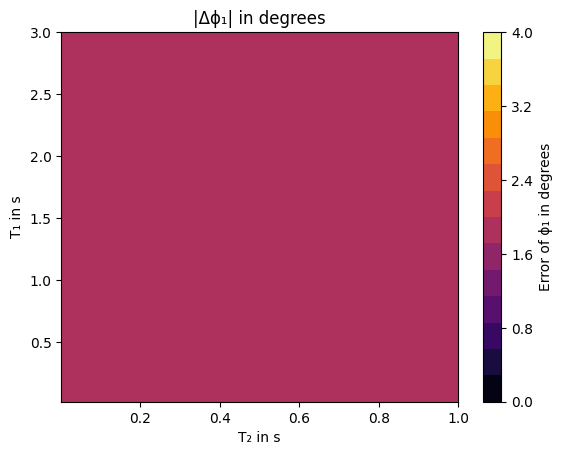

In [3]:
# Plot functions
def plot_error_map(fig_num, T2, T1, error_matrix, title, colorbar_label, xmin=None, xmax=None):

    if xmin is None:
        xmin = np.min(error_matrix)  # Default: min of the data
    if xmax is None:
        xmax = np.max(error_matrix)  # Default: max of the data

    levels = np.linspace(xmin, xmax, 15)  # Define contour levels within range

    plt.figure(fig_num)
    contour = plt.contourf(T2, T1, error_matrix, levels=levels, cmap='inferno')
    cbar = plt.colorbar(contour)
    cbar.set_label(colorbar_label)
    cbar.set_ticks(np.linspace(xmin, xmax, 6))  # 6 evenly spaced ticks
    contour.set_clim(xmin, xmax)


    plt.xlabel('T₂ in s')
    plt.ylabel('T₁ in s')
    plt.title(title)
    plt.show()
# Plot results
plot_error_map(2, T2vec, T1vec, T1error, '|ΔT₁| in %', 'Relative error of T₁ in %',0,15)
plot_error_map(4, T2vec, T1vec, T2error, '|ΔT₂| in %', 'Relative error of T₂ in %',0,15)
plot_error_map(5, T2vec, T1vec, M0error, '|ΔM₀| in %', 'Relative error of M₀ in %',0,5)
plot_error_map(7, T2vec, T1vec, B0error, '|Δϕ₁| in degrees', 'Error of ϕ₁ in degrees',0,4)